# Vision brain alignment : inferring IT neural activity

⚠️ For reproducing final results, please directly jump to the **Model** part.

Else, **Preliminary work** contains all work done to provide a pipeline for predicting neural activity of 168 IT neurons from image stimuli. The dataset is derived from this [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf).

Notebook by Arthur Chansel, Yann Ennassih, Bryan Gotti


## Imports, utils, data loading

In [1]:
from typing import List, Callable, Dict
import h5py
import copy
import re
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import explained_variance_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import torch
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation done on {device}")

blue, orange, green = '#1f77b4', '#ff7f0e', '#2ca02c'

/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Computation done on cuda


In [39]:
def load_it_data(path_to_data):
    """ Load IT data

    Args:
        path_to_data (str): Path to the data

    Returns:
        np.array (x6): Stimulus train/val/test; objects list train/val/test; spikes train/val
    """

    datafile = h5py.File(os.path.join(path_to_data,'IT_data.h5'), 'r')

    stimulus_train = datafile['stimulus_train'][()]
    spikes_train = datafile['spikes_train'][()]
    objects_train = datafile['object_train'][()]
    
    stimulus_val = datafile['stimulus_val'][()]
    spikes_val = datafile['spikes_val'][()]
    objects_val = datafile['object_val'][()]
    
    stimulus_test = datafile['stimulus_test'][()]
    objects_test = datafile['object_test'][()]

    ### Decode back object type to latin
    objects_train = [obj_tmp.decode("latin-1") for obj_tmp in objects_train]
    objects_val = [obj_tmp.decode("latin-1") for obj_tmp in objects_val]
    objects_test = [obj_tmp.decode("latin-1") for obj_tmp in objects_test]

    return stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val

def correlation_score(y_true, y_pred):
    return np.array([np.corrcoef(y_true[:,neuron], y_pred[:,neuron])[0,1] for neuron in range(y_pred.shape[1])])

def evaluate(predictions, spikes, keys, bins=30, ev_range=(-2.5,1)):

    n_predictions = len(keys)
    evaluated_predictions = {k: v for k,v in predictions.items() if k in keys}

    f, axs = plt.subplots(n_predictions, 2, figsize=(10, 3*n_predictions), squeeze=False)

    for i, (key, pred) in enumerate(evaluated_predictions.items()):
        
        for background_key in keys[key]:
            print()
            background_pred = predictions[background_key]

            ev = explained_variance_score(spikes, background_pred, multioutput='raw_values')
            corr = correlation_score(spikes, background_pred)
    
            axs[i, 0].hist(ev, bins=bins, range=ev_range, alpha=0.3)
            axs[i, 1].hist(corr, bins=bins, range=(-0.5,1), alpha=0.3)

        ev = explained_variance_score(spikes, pred, multioutput='raw_values')
        corr = correlation_score(spikes, pred)
        
        print(f"--- {key} ---")
        print("Mean EV:", ev.mean())
        print("Mean Pearson correlation:", corr.mean())

        axs[i, 0].hist(ev, bins=bins, range=ev_range, edgecolor='black', alpha=0.7)
        axs[i, 0].set_title(f'{key} - Explained variance')
        axs[i, 0].set_xlabel('EV')
        axs[i, 0].set_ylabel('Neurons count')

        axs[i, 1].hist(corr, bins=bins, range=(-0.5,1), edgecolor='black', alpha=0.7)
        axs[i, 1].set_title(f'{key} - Correlation')
        axs[i, 1].set_xlabel('Correlation coefficient')
        axs[i, 1].set_ylabel('Neurons count')

    plt.tight_layout()
    plt.show()

def compare_metrics(metric_fn: Callable[[np.ndarray, np.ndarray], float],
                    y_true: np.ndarray,
                    predictions: Dict[str, np.ndarray],
                    key_before: str,
                    key_after: str,
                    metric_name: str) -> None:
    """Compare metrics before and after a change in the model.
    Args:
        metric_fn (Callable): Function to compute the metric
        y_true (np.ndarray): True spike values
        predictions (Dict[str, np.ndarray]): Dictionary of predictions
        key_before (str): Key for the predictions before the change
        key_after (str): Key for the predictions after the change
        metric_name (str): Name of the metric
    """
    before = metric_fn(y_true, predictions[key_before])
    after = metric_fn(y_true, predictions[key_after])
    print(f"{metric_name}: after {after} - before {before}")
    print(f"{metric_name} residual {after - before}\n")

def train_model(model, loss_fn, opt, train_loader, val_inputs, val_targets, metric_fn, epochs):
    """
    Train the model using the provided loss function and optimizer.
    Args:
        model (torch.nn.Module): The model to train.
        loss_fn (callable): The loss function to use.
        opt (torch.optim.Optimizer): The optimizer to use.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        metric_fn (callable): The metric function to use for evaluation.
        epochs (int): Number of epochs to train for.
    """
    for ep in range(epochs):
        # Training
        model.train()
        for it, batch in enumerate(train_loader):
            inputs, targets = batch

            # Run forward pass
            predictions = model(inputs)
            
            # Compute loss
            loss = loss_fn(predictions, targets)
            
            # Run backward pass
            loss.backward()
            
            # Update the weights using optimizer
            opt.step()
            
            # Zero-out the accumualted gradients
            opt.zero_grad()

            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, len(train_loader), loss), end='')

        # Validation
        model.eval()
        with torch.no_grad():
            metric = metric_fn(val_targets.detach().cpu().numpy(), model(val_inputs).detach().cpu().numpy())
            print(', metric validation: {:.2f}'.format(metric))

    print(" ")

class SpikesCNN(nn.Module):
    def __init__(self, input_size=224, input_channels=3, num_filters=(8, 16), num_hidden=4096, output_size=168):
        """
        Args:
            input_size (int): Size of one side of the input images (assumed square). Note that given the two
            pooling layers, the input size should be divisible by 4.
            input_channels (int): Number of channels in the input images (e.g., 3 for RGB).
            num_filters (tuple): Number of filters for each convolutional layer.
            num_hidden (int): Number of hidden units in the fully connected layer.
        """
        super(SpikesCNN, self).__init__()
        assert input_size % 4 == 0, "Input size must be divisible by 4 due to pooling layers."
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size=5, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=5, padding="same")
        self.fc1 = nn.Linear(num_filters[1] * int(input_size / 4)**2, num_hidden)
        self.fc2 = nn.Linear(num_hidden, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class SpikesDataset(Dataset):
    def __init__(self, stimuli, spikes, device):
        self.stimuli = torch.tensor(stimuli, dtype=torch.float32, device=device)
        self.spikes = torch.tensor(spikes, dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimulus = self.stimuli[idx]
        spike = self.spikes[idx]
        return stimulus, spike
    
class ObjectsDataset(Dataset):
    def __init__(self, stimuli, objects, device):
        self.stimuli = torch.tensor(stimuli, dtype=torch.float32, device=device)
        self.objects = torch.tensor(objects, dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimulus = self.stimuli[idx]
        object = self.objects[idx]
        return stimulus, object
    
    
class ActivationsDataset(Dataset):
    def __init__(self, activations, spikes, device):
        self.activations = activations
        self.spikes = spikes

    def __len__(self):
        return len(self.activations)

    def __getitem__(self, idx):
        activation = self.activations[idx]
        spike = self.spikes[idx]
        return activation, spike
    
class SpikesCNN(nn.Module):
    def __init__(self, input_size=224, input_channels=3, num_filters=(8, 16), num_hidden=4096, output_size=168):
        """
        Args:
            input_size (int): Size of one side of the input images (assumed square). Note that given the two
            pooling layers, the input size should be divisible by 4.
            input_channels (int): Number of channels in the input images (e.g., 3 for RGB).
            num_filters (tuple): Number of filters for each convolutional layer.
            num_hidden (int): Number of hidden units in the fully connected layer.
        """
        super(SpikesCNN, self).__init__()
        assert input_size % 4 == 0, "Input size must be divisible by 4 due to pooling layers."
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size=5, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=5, padding="same")
        self.fc1 = nn.Linear(num_filters[1] * int(input_size / 4)**2, num_hidden)
        self.fc2 = nn.Linear(num_hidden, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class SmallSpikesCNN(nn.Module):
    def __init__(self, input_size=224, input_channels=3, num_filters=(4, 8, 8), num_hidden=2048, output_size=168):
        """
        Args:
            input_size (int): Size of one side of the input images (assumed square). Note that given the
            pooling layers, the input size should be divisible by 8.
            input_channels (int): Number of channels in the input images (e.g., 3 for RGB).
            num_filters (tuple): Number of filters for each convolutional layer.
            num_hidden (int): Number of hidden units in the fully connected layer.
        """
        super(SmallSpikesCNN, self).__init__()
        assert input_size % 8 == 0, "Input size must be divisible by 4 due to pooling layers."
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(num_filters[2] * int(input_size / 8)**2, num_hidden)
        self.fc2 = nn.Linear(num_hidden, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def extract_activations(model, imgs_tr, imgs_val, return_nodes):

    activations_tr = []
    activations_val = []

    for return_node in return_nodes:

        print(f"Extracting {return_node}...")
        # Place hook on wanted layer
        extractor = create_feature_extractor(model, return_nodes={return_node:return_node})
        extractor.eval()

        with torch.no_grad():

            # Forward training set
            activation_tr = extractor(imgs_tr)[return_node]
            activation_tr = activation_tr.flatten(1)

            U, S, V = torch.pca_lowrank(activation_tr, 1000) # pca performed on gpu
            activation_tr = activation_tr @ V
            activations_tr.append(activation_tr.cpu())
            del activation_tr, U, S

            # Forward validation set
            activation_val = extractor(imgs_val)[return_node]
            activation_val = activation_val.flatten(1) @ V
            activations_val.append(activation_val.cpu())
            del activation_val, V
            
        torch.cuda.empty_cache()
        del extractor,

    del model
    print(" ")
    
    return activations_tr, activations_val

### Data loading ###

In [3]:
path_to_data = 'brainlike/'

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
x_train = stimulus_train.reshape((stimulus_train.shape[0], -1)) # flattened images used for linear regression
x_val = stimulus_val.reshape((stimulus_val.shape[0], -1))

n_stimulus = stimulus_train.shape[0]
n_neurons = spikes_train.shape[1]

print(f"Image stimuli of shapes: train {stimulus_train.shape} validation {stimulus_val.shape}")
print(f"Flattened stimuli of shapes: train {x_train.shape} validation {x_val.shape}")
print(f"Neural activity of shapes: train {spikes_train.shape} validation {spikes_val.shape}")

Image stimuli of shapes: train (2592, 3, 224, 224) validation (288, 3, 224, 224)
Flattened stimuli of shapes: train (2592, 150528) validation (288, 150528)
Neural activity of shapes: train (2592, 168) validation (288, 168)


## Linear regression

/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=4.7811e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


--- least_squares ---
Mean EV: -1.1615338183584667
Mean Pearson correlation: 0.14653545475356106
--- ridge ---
Mean EV: -1.1573757976293564
Mean Pearson correlation: 0.14668690500674206


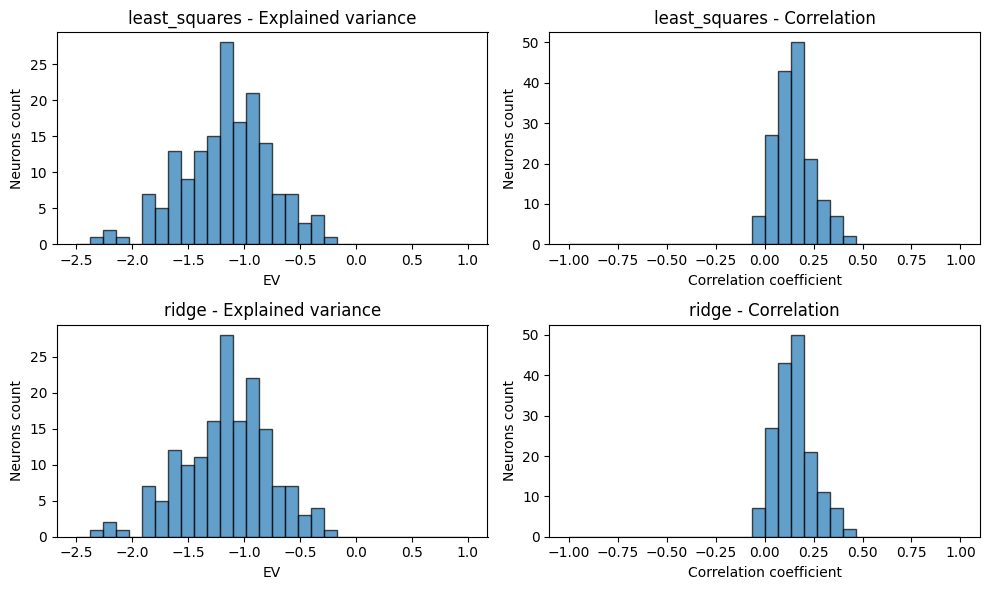

In [4]:
predictions = {}

# Ordinary Least-Squares
least_squares = LinearRegression()
least_squares.fit(x_train, spikes_train)
predictions['least_squares'] = least_squares.predict(x_val)

# Ridge Regression
ridge = Ridge()
ridge.fit(x_train, spikes_train)
predictions['ridge'] = ridge.predict(x_val)

# Evaluate and plot
keys = {'least_squares': [], 'ridge': []} # empty values means no background plot
evaluate(predictions, spikes_val, keys)

From this first naive approach, OLS and Ridge have similar poor fit.


--- pca_least_squares ---
Mean EV: -0.08728544697875068
Mean Pearson correlation: 0.2157467992848962

--- pca_ridge ---
Mean EV: -0.0872652775474957
Mean Pearson correlation: 0.2157505576274775


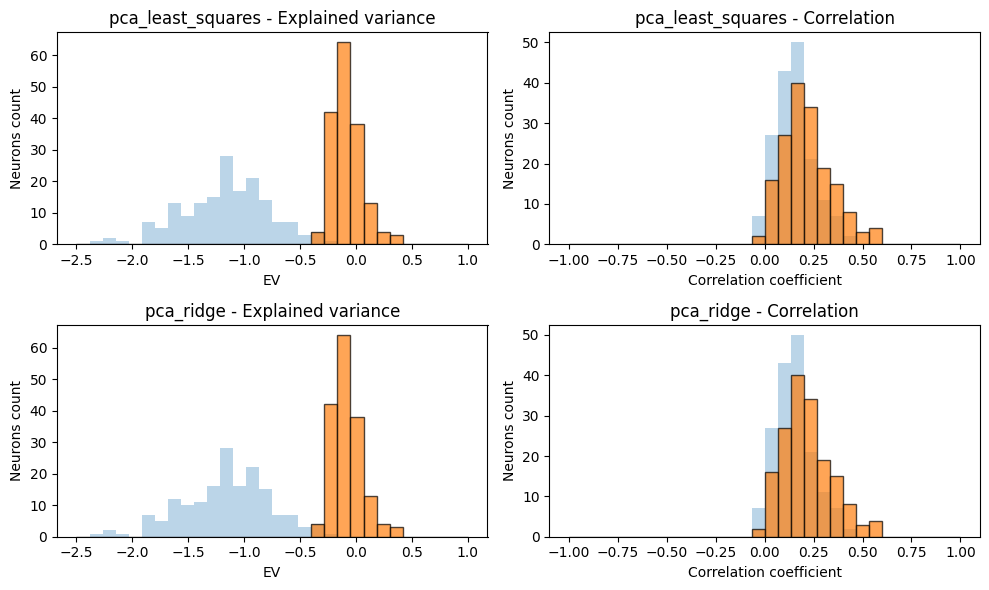

In [5]:
# Using principal components
pca = PCA(n_components=1000)
x_train_pcs = pca.fit_transform(x_train)
x_val_pcs = pca.transform(x_val)

least_squares = LinearRegression()
least_squares.fit(x_train_pcs, spikes_train)
predictions['pca_least_squares'] = least_squares.predict(x_val_pcs)
                                                
ridge = Ridge()
ridge.fit(x_train_pcs, spikes_train)
predictions['pca_ridge'] = ridge.predict(x_val_pcs)

keys = {'pca_least_squares': ['least_squares'], 'pca_ridge': ['ridge']}
evaluate(predictions, spikes_val, keys)

Linear dimensionality reduction considerably improves both fits.

Best alpha: 343046.93


--- tuned_pca_ridge ---
Mean EV: 0.09242318783487592
Mean Pearson correlation: 0.2848479713137508


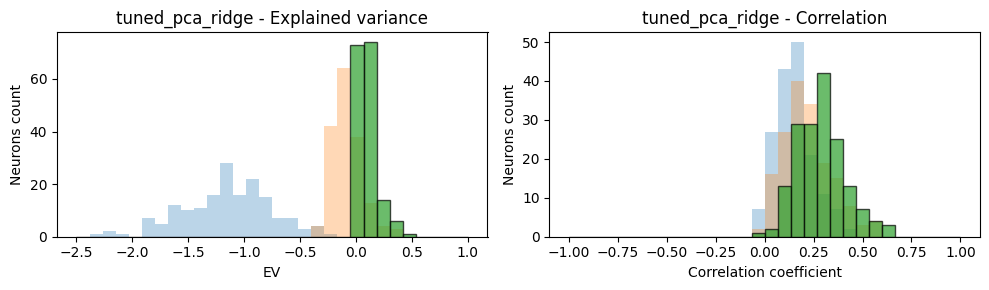

In [ ]:
# Cross validation to find best Ridge regularization parameter
param_grid = {'alpha': np.logspace(-3, 10, 100)}
cv = StratifiedKFold(shuffle=True)

cv_ridge = GridSearchCV(ridge, param_grid, cv=cv.split(np.zeros(n_stimulus), objects_train), scoring='explained_variance', n_jobs=-1)
cv_ridge.fit(x_train_pcs, spikes_train)
best_ridge = cv_ridge.best_estimator_
best_alpha = cv_ridge.best_params_['alpha']
print(f"Best alpha: {best_alpha:.2f}")

predictions["tuned_pca_ridge"] = best_ridge.predict(x_val_pcs)

keys = {'tuned_pca_ridge': ['ridge', 'pca_ridge']}
evaluate(predictions, spikes_val, keys)

Fine tuning the regularization scale parameter of the Ridge estimator slightly improves the fit.

## Task-driven approach

Do complex layer activations trained on object recognition predict IT spiking activities ?

In [40]:
imgs_tr = torch.from_numpy(stimulus_train).to(device)
imgs_val = torch.from_numpy(stimulus_val).to(device)

return_nodes = ['conv1','layer1','layer2','layer3','layer4','avgpool']

print("--- Pretrained Resnet50 --- ")
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

activations_tr, activations_val = extract_activations(model, imgs_tr, imgs_val, return_nodes)

print("--- Random initialized Resnet50 ---")
model = resnet50() 
model = model.to(device)
model.eval()

rand_activations_tr, rand_activations_val = extract_activations(model, imgs_tr, imgs_val, return_nodes)

--- Pretrained Resnet50 --- 
Extracting conv1...
Extracting layer1...
Extracting layer2...
Extracting layer3...
Extracting layer4...
Extracting avgpool...
 
--- Random initialized Resnet50 ---
Extracting conv1...
Extracting layer1...
Extracting layer2...
Extracting layer3...
Extracting layer4...
Extracting avgpool...
 



--- conv1 ---
Mean EV: -0.028231406801785507
Mean Pearson correlation: 0.23720517965447682

--- layer1 ---
Mean EV: 0.25643434410400445
Mean Pearson correlation: 0.49414843624173016

--- layer2 ---
Mean EV: 0.33189868859134813
Mean Pearson correlation: 0.5651780049099618

--- layer3 ---
Mean EV: 0.40743276475615225
Mean Pearson correlation: 0.629364515654932

--- layer4 ---
Mean EV: 0.3551805804101108
Mean Pearson correlation: 0.5921738996491993

--- avgpool ---
Mean EV: 0.1266538313172441
Mean Pearson correlation: 0.4719441298722128


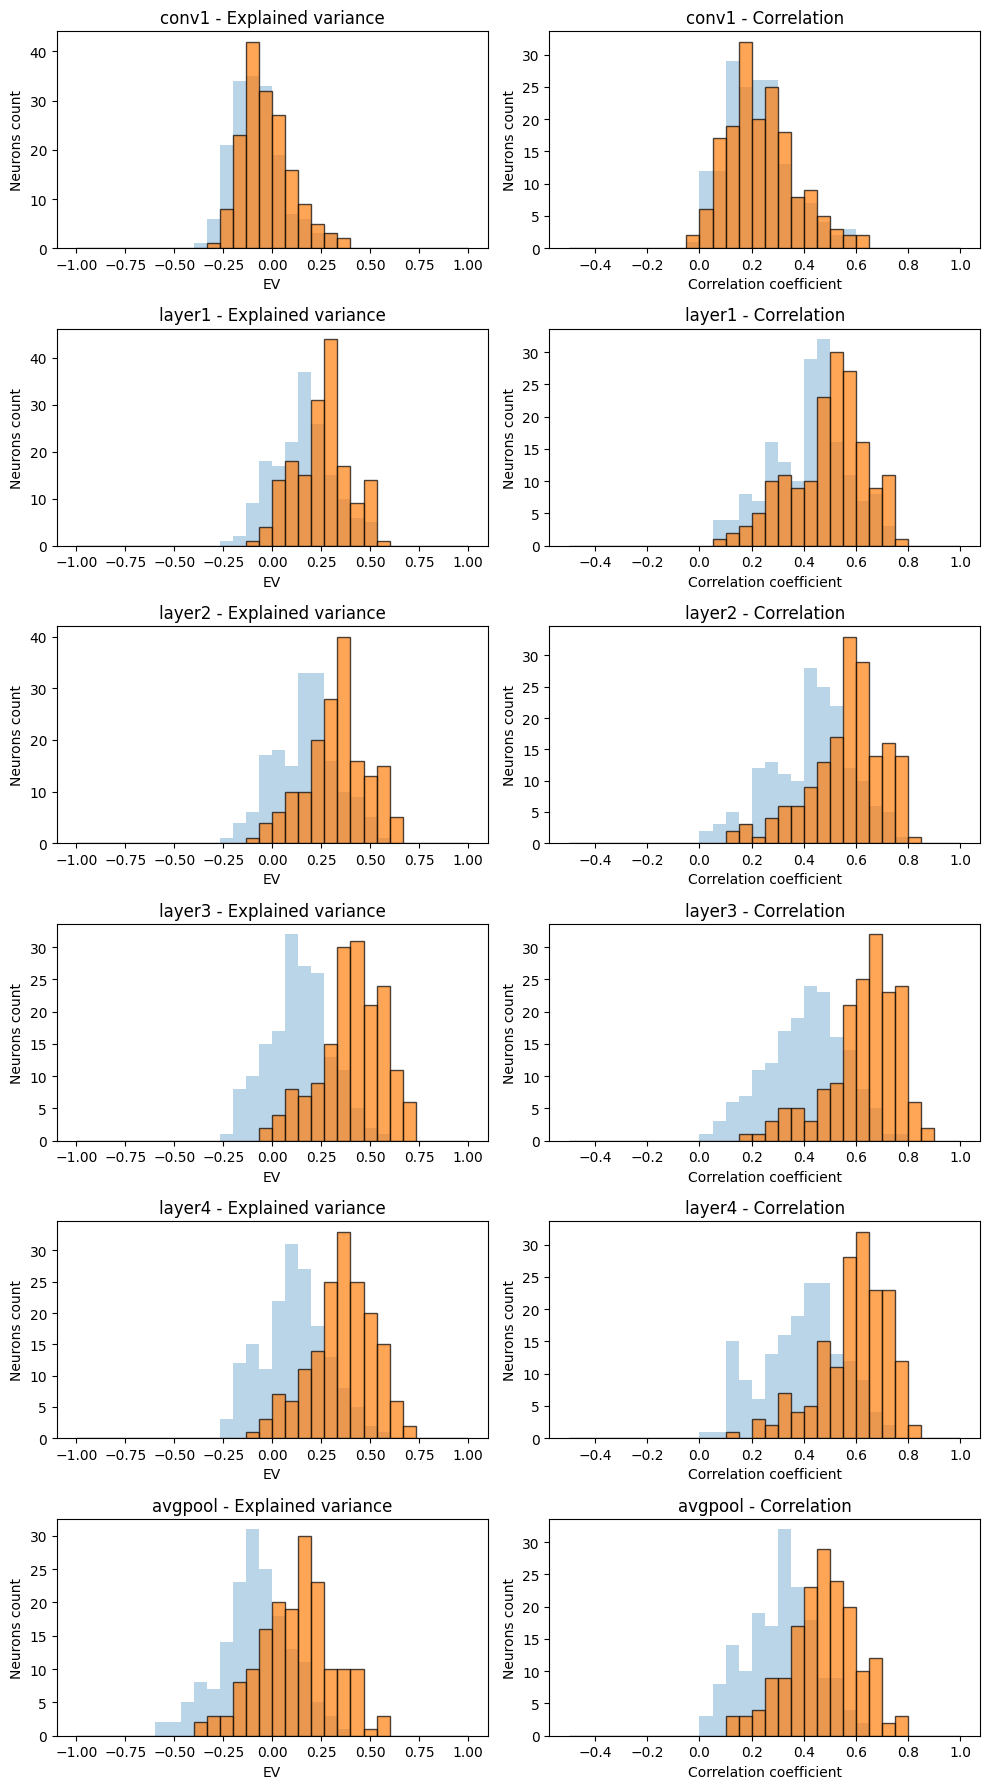

In [41]:
for i in range(len(return_nodes)):
    return_node = return_nodes[i]

    reg = Ridge()
    reg.fit(activations_tr[i], spikes_train)
    y_pred = reg.predict(activations_val[i])
    predictions[return_node] = reg.predict(activations_val[i])

    rand_reg = Ridge()
    rand_reg.fit(rand_activations_tr[i], spikes_train)
    predictions["rand_" + return_node] = rand_reg.predict(rand_activations_val[i])

keys = {
    'conv1': ['rand_conv1'],
    'layer1': ['rand_layer1'],
    'layer2': ['rand_layer2'],
    'layer3': ['rand_layer3'], 
    'layer4': ['rand_layer4'],
    'avgpool': ['rand_avgpool']
    }
evaluate(predictions, spikes_val, keys, ev_range=(-1,1))

As expected, pretrained (orange) internal representations better explaines the neural spiking than random initialized ones (blue).

## Data-driven approach

How well does training CNNs to directly fit the spiking activity from the images work ?

In [ ]:
train_dataset = SpikesDataset(stimulus_train, spikes_train, device)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_inputs = torch.tensor(stimulus_val, dtype=torch.float32, device=device)
val_targets = torch.tensor(spikes_val, dtype=torch.float32, device=device)

# Display 1st batch shape
for stimuli_batch, spikes_batch in train_loader:
    print(f"Stimuli batch shape: {stimuli_batch.shape}")
    print(f"Spikes batch shape: {spikes_batch.shape}")
    break

Stimuli batch shape: torch.Size([8, 3, 224, 224])
Spikes batch shape: torch.Size([8, 168])


In [8]:
model = SpikesCNN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=10)

Ep 1/10, it 324/324: loss train: 0.12, metric validation: 0.10
Ep 2/10, it 324/324: loss train: 0.09, metric validation: 0.17
Ep 3/10, it 324/324: loss train: 0.11, metric validation: 0.20
Ep 4/10, it 324/324: loss train: 0.09, metric validation: 0.17
Ep 5/10, it 324/324: loss train: 0.07, metric validation: 0.19
Ep 6/10, it 324/324: loss train: 0.05, metric validation: 0.20
Ep 7/10, it 324/324: loss train: 0.06, metric validation: 0.20
Ep 8/10, it 324/324: loss train: 0.05, metric validation: 0.19
Ep 9/10, it 324/324: loss train: 0.05, metric validation: 0.18
Ep 10/10, it 324/324: loss train: 0.06, metric validation: 0.18


After 3 epochs, it has already overfitted the training set. Let's try to make the model smaller:

In [ ]:
print("--- SmallSpikesCNN ---")
small_model = SmallSpikesCNN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(small_model.parameters(), lr=0.001)

train_model(small_model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=10)

print("--- VerySmallSpikesCNN ---")
very_small_model = SmallSpikesCNN(num_filters=(2, 4, 4), num_hidden=256).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(very_small_model.parameters(), lr=0.001)

train_model(small_model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=10)

--- SmallSpikesCNN ---
Ep 1/10, it 324/324: loss train: 0.09, metric validation: 0.20
Ep 2/10, it 324/324: loss train: 0.10, metric validation: 0.25
Ep 3/10, it 324/324: loss train: 0.11, metric validation: 0.26
Ep 4/10, it 324/324: loss train: 0.07, metric validation: 0.25
Ep 5/10, it 324/324: loss train: 0.05, metric validation: 0.25
Ep 6/10, it 324/324: loss train: 0.06, metric validation: 0.25
Ep 7/10, it 324/324: loss train: 0.03, metric validation: 0.22
Ep 8/10, it 324/324: loss train: 0.04, metric validation: 0.23
Ep 9/10, it 324/324: loss train: 0.04, metric validation: 0.22
Ep 10/10, it 324/324: loss train: 0.03, metric validation: 0.22
 
--- VerySmallSpikesCNN ---
Ep 1/10, it 324/324: loss train: 0.03, metric validation: 0.22
Ep 2/10, it 324/324: loss train: 0.03, metric validation: 0.22
Ep 3/10, it 324/324: loss train: 0.04, metric validation: 0.22
Ep 4/10, it 324/324: loss train: 0.03, metric validation: 0.22
Ep 5/10, it 324/324: loss train: 0.02, metric validation: 0.22
Ep

We see that a model that is too small is no longer able to learn the task well enough. We will thus keep the `small_model` as our final data-driven model, trained for 3 epochs.

Ep 1/3, it 324/324: loss train: 0.10, metric validation: 0.18
Ep 2/3, it 324/324: loss train: 0.10, metric validation: 0.21
Ep 3/3, it 324/324: loss train: 0.08, metric validation: 0.24
 
--- SmallSpikesCNN ---
Mean EV: 0.2369552446263177
Mean Pearson correlation: 0.47218981357308415


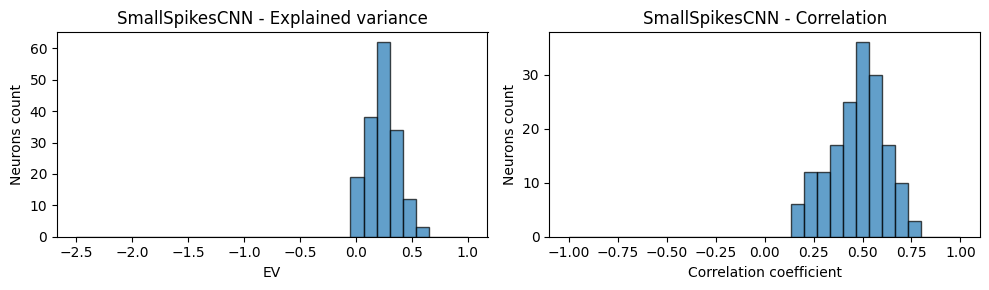

In [ ]:
model = SmallSpikesCNN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=3)

model.eval()
predictions = {"SmallSpikesCNN": model(val_inputs).detach().cpu().numpy()}
keys = {"SmallSpikesCNN": []}
evaluate(predictions, spikes_val, keys, ev_range=(-1, 1))

Results show comparable or slightly worse performance than layers of the pretrained resnet50. 

## Further investigation

The following complementary study is based on the pretrained "Barlow Twins: Self-Supervised Learning via Redundancy Reduction" resnet50-based model.
This model achieves rank 1 Brain-Score on the MajajHong2015-IT dataset and IT neurons best align with 'layer4.0'.

SRC : https://www.brain-score.org/model/vision/1310 & https://github.com/facebookresearch/barlowtwins


In [45]:
return_nodes = ['layer4.0']

print("--- Pretrained Resnet50-barlow --- ")
model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model = model.to(device)
model.eval()

activations_tr, activations_val = extract_activations(model, imgs_tr, imgs_val, return_nodes)
actavation_tr, activation_val = activations_tr[0], activations_val[0]

--- Pretrained Resnet50-barlow --- 


Using cache found in /home/ennassih/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Extracting layer4.0...
 


Best alpha: 22570.20
--- tuned_ridge_pca_barlow ---
Mean EV: 0.45524075338602965
Mean Pearson correlation: 0.6672893979659721


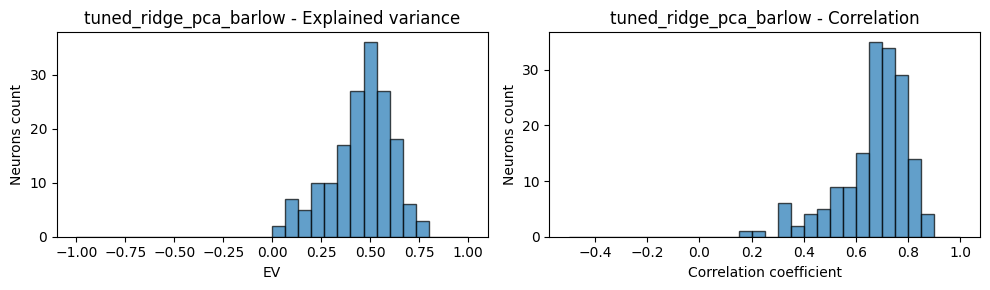

In [ ]:
# Cross validation to find best Ridge regularization parameter
param_grid = {'alpha': np.logspace(-3, 10, 100)}
cv = StratifiedKFold(shuffle=True)

cv_ridge = GridSearchCV(ridge, param_grid, cv=cv.split(np.zeros(n_stimulus), objects_train), scoring='explained_variance', n_jobs=-1)
cv_ridge.fit(actavation_tr, spikes_train)
best_ridge = cv_ridge.best_estimator_
best_alpha = cv_ridge.best_params_['alpha']
print(f"Best alpha: {best_alpha:.2f}")

predictions["tuned_ridge_pca_barlow"] = best_ridge.predict(activation_val)

keys = {'tuned_ridge_pca_barlow': []}
evaluate(predictions, spikes_val, keys, ev_range=(-1,1))

The Barlow layer4.0 outperforms all previous work. But maybe adding a fully connected network (hence a non-linear function) on top of it improves the performance ?



### Data-driven feed forward neural network

### Model loading



In [ ]:
model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model = model.to(device)
model.eval() # freeze the pretrained weights

return_node = 'layer4.0'

# Model